# Importar librerías

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import random, where

import sklearn.cluster as cluster

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.manifold import TSNE

# Ignorar advertencias
import warnings
warnings.filterwarnings("ignore")

In [5]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached hdbscan-0.8.29.tar.gz (5.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp310-cp310-linux_x86_64.whl size=3541480 sha256=8f483f9c2aeb9570c83a45de7f927318369f42e939c920699aefef5f53d7d73a
  Stored in directory: /root/.cache/pip/wheels/dc/52/e3/6c6b60b126b4d5c4370cb5ac071b82950f91649d62d72f7f56
Successfully built hdbscan


In [6]:
import hdbscan

# Importar y mostrar data

In [7]:
df = pd.read_csv("leukemia_dataset.csv")

In [8]:
df.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,1,Bone_Marrow_CD34,7.745245,7.811210,6.477916,8.841506,4.546941,7.957714,5.344999,4.673364,...,5.058849,6.810004,12.800060,12.718612,5.391512,4.666166,3.974759,3.656693,4.160622,4.139249
1,12,Bone_Marrow_CD34,8.087252,7.240673,8.584648,8.983571,4.548934,8.011652,5.579647,4.828184,...,4.436153,6.751471,12.472706,12.333593,5.379738,4.656786,4.188348,3.792535,4.204414,4.122700
2,13,Bone_Marrow_CD34,7.792056,7.549368,11.053504,8.909703,4.549328,8.237099,5.406489,4.615572,...,4.392061,6.086295,12.637384,12.499038,5.316604,4.600566,3.845561,3.635715,4.174199,4.067152
3,14,Bone_Marrow_CD34,7.767265,7.094460,11.816433,8.994654,4.697018,8.283412,5.582195,4.903684,...,4.633334,6.375991,12.903630,12.871454,5.179951,4.641952,3.991634,3.704587,4.149938,3.910150
4,15,Bone_Marrow_CD34,8.010117,7.405281,6.656049,9.050682,4.514986,8.377046,5.493713,4.860754,...,5.305192,6.700453,12.949352,12.782515,5.341689,4.560315,3.887020,3.629853,4.127513,4.004316


In [9]:
# Número de filas y columnas en el dataset
nRow, nCol = df.shape
print(f'Hay {nRow} filas y {nCol} columnas en el dataset de leucemia')

Hay 64 filas y 22285 columnas en el dataset de leucemia


In [10]:
# Buscar valores nulos en el dataset
df.isnull().sum()

samples            0
type               0
1007_s_at          0
1053_at            0
117_at             0
                  ..
AFFX-ThrX-5_at     0
AFFX-ThrX-M_at     0
AFFX-TrpnX-3_at    0
AFFX-TrpnX-5_at    0
AFFX-TrpnX-M_at    0
Length: 22285, dtype: int64

In [11]:
# Revisar el total de valores nulos
df.isnull().sum().sum()

0

In [12]:
# Identificar la distribución según el tipo de muestra.
# Cada 'type' corresponde a un tipo de leucemia
label_count = df['type'].value_counts()
label_count

AML                 26
Bone_Marrow         10
PB                  10
PBSC_CD34           10
Bone_Marrow_CD34     8
Name: type, dtype: int64

Text(0.5, 1.0, 'Distribución de variable "type" en los datos')

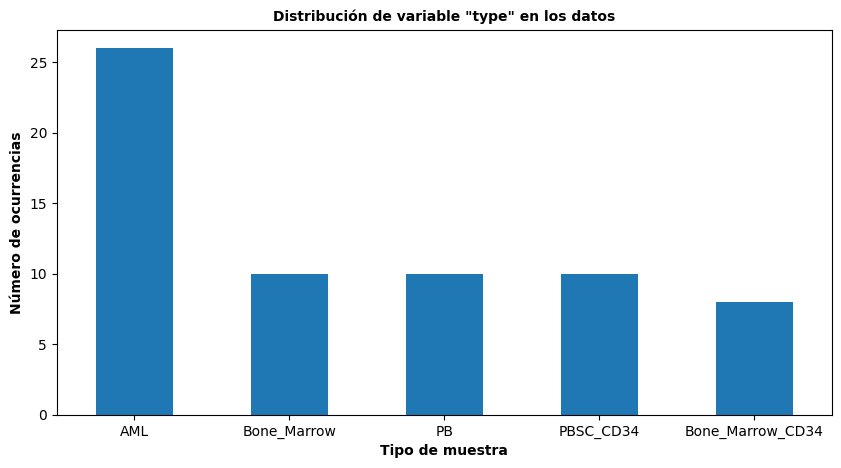

In [13]:
# Visualizar la distribución por tipo de muestra
fig = plt.figure(figsize=(10, 5))
df['type'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('Número de ocurrencias', fontsize=10, fontweight='bold')
plt.xlabel('Tipo de muestra', fontsize=10, fontweight='bold')
plt.title('Distribución de variable "type" en los datos', fontsize=10, fontweight='bold')

# Preparación de Data para Clustering

In [14]:
# Asignar etiquetas a la variable y
y = df['type']
y

0     Bone_Marrow_CD34
1     Bone_Marrow_CD34
2     Bone_Marrow_CD34
3     Bone_Marrow_CD34
4     Bone_Marrow_CD34
            ...       
59           PBSC_CD34
60           PBSC_CD34
61           PBSC_CD34
62           PBSC_CD34
63           PBSC_CD34
Name: type, Length: 64, dtype: object

In [15]:
# seleccionar datos categoricos
X = df.iloc[:,2:].values
X

array([[ 7.745245  ,  7.81121008,  6.47791635, ...,  3.65669312,
         4.16062155,  4.13924885],
       [ 8.08725201,  7.24067331,  8.58464841, ...,  3.7925346 ,
         4.20441384,  4.12269984],
       [ 7.79205558,  7.54936776, 11.05350405, ...,  3.63571499,
         4.17419912,  4.06715189],
       ...,
       [ 7.86309208,  6.89624162,  6.63068969, ...,  3.66871266,
         4.16222013,  4.1022645 ],
       [ 7.90099218,  6.78751502,  6.64292725, ...,  3.57056287,
         4.14137082,  4.10264116],
       [ 8.00448759,  6.65743335,  6.70559658, ...,  3.63836663,
         4.15684155,  4.17986705]])

Antes de aplicar el Clustering, escalamos nuestros datos de modo que cada característica tenga una varianza unitaria.

In [16]:
scaler = StandardScaler()

In [17]:
X_scaled = scaler.fit_transform(X)

In [18]:
X_scaled

array([[-0.43992241,  2.8478943 , -0.76859606, ...,  0.27541129,
         0.24991515,  0.21553881],
       [ 1.58981201,  1.31612913,  0.8544001 , ...,  2.21934709,
         0.81095432,  0.06053528],
       [-0.1621122 ,  2.14490552,  2.75637108, ..., -0.02479251,
         0.42386234, -0.45974533],
       ...,
       [ 0.25947342,  0.39140612, -0.65090167, ...,  0.4474148 ,
         0.27039515, -0.13086892],
       [ 0.48440197,  0.09949924, -0.64147403, ..., -0.95714056,
         0.00328686, -0.127341  ],
       [ 1.09862386, -0.24974133, -0.59319447, ...,  0.01315327,
         0.20148806,  0.59598246]])

# Modelo de Clustering [1][2]

In [19]:
# Inicialiar modelo
clusterer = hdbscan.HDBSCAN()

In [20]:
# Podemos este modelo de Clustering y ajustarlo a los datos que tenemos.
clusterer.fit(X_scaled)

HDBSCAN()

El objeto clusterer almacena el resultado en un atributo label_.

In [21]:
clusterer.labels_, clusterer.labels_.max()

(array([ 0, -1,  0, -1,  0,  0, -1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,
        -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,  2, -1, -1, -1,  2,  2,
        -1,  2,  2,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0]),
 2)

Tenemos un total de tres grupos, con etiquetas 0, 1 y 2.

Es importante destacar que HDBSCAN tiene en cuenta el ruido: tiene una noción de muestras de datos que no están asignadas a ningún grupo. Esto se maneja asignando a estas muestras la etiqueta -1.


In [22]:
clusterer.probabilities_

array([0.91326113, 0.        , 0.99002037, 0.        , 0.95635178,
       0.91326113, 0.        , 0.95221394, 0.81092   , 0.95243113,
       0.91666386, 0.98214912, 1.        , 1.        , 1.        ,
       0.98270124, 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.88036748, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.88286464,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       1.        , 0.        , 1.        , 1.        , 0.99590994,
       1.        , 0.92539672, 0.        , 1.        , 0.99904567,
       0.99002037, 1.        , 1.        , 1.        ])

Hay diferentes métricas disponibles, a través de sklearn

In [23]:
hdbscan.dist_metrics.METRIC_MAPPING

{'euclidean': hdbscan.dist_metrics.EuclideanDistance,
 'l2': hdbscan.dist_metrics.EuclideanDistance,
 'minkowski': hdbscan.dist_metrics.MinkowskiDistance,
 'p': hdbscan.dist_metrics.MinkowskiDistance,
 'manhattan': hdbscan.dist_metrics.ManhattanDistance,
 'cityblock': hdbscan.dist_metrics.ManhattanDistance,
 'l1': hdbscan.dist_metrics.ManhattanDistance,
 'chebyshev': hdbscan.dist_metrics.ChebyshevDistance,
 'infinity': hdbscan.dist_metrics.ChebyshevDistance,
 'seuclidean': hdbscan.dist_metrics.SEuclideanDistance,
 'mahalanobis': hdbscan.dist_metrics.MahalanobisDistance,
 'wminkowski': hdbscan.dist_metrics.WMinkowskiDistance,
 'hamming': hdbscan.dist_metrics.HammingDistance,
 'canberra': hdbscan.dist_metrics.CanberraDistance,
 'braycurtis': hdbscan.dist_metrics.BrayCurtisDistance,
 'matching': hdbscan.dist_metrics.MatchingDistance,
 'jaccard': hdbscan.dist_metrics.JaccardDistance,
 'dice': hdbscan.dist_metrics.DiceDistance,
 'kulsinski': hdbscan.dist_metrics.KulsinskiDistance,
 'rogerst

Probamos con otra metrica para comparar el resultado

In [24]:
clusterer = hdbscan.HDBSCAN(metric='l1', min_cluster_size=6, min_samples=1)
clusterer.fit(X_scaled)
clusterer.labels_

array([ 1,  1,  1,  1,  1,  1, -1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,
       -1, -1, -1, -1, -1,  1, -1,  1,  1, -1,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

<Axes: ylabel='$\\lambda$ value'>

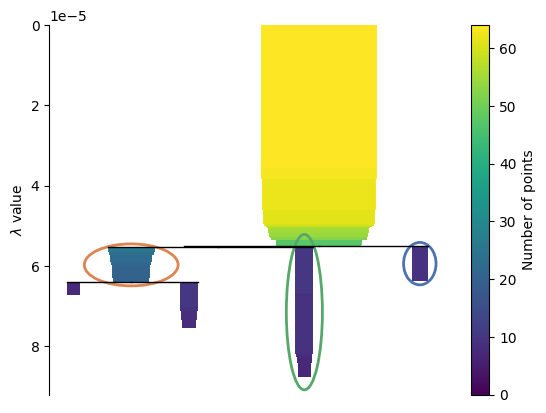

In [25]:
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

A pesar de haber cambiado las metricas, el agrupamiento no parece dar un resultado coherente.

## Aplicar PCA a los datos antes de la agrupación

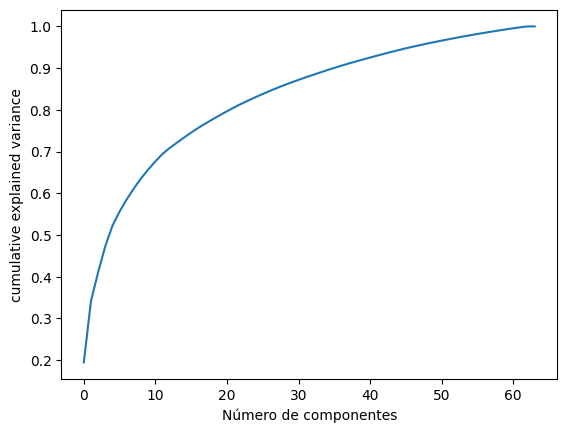

In [26]:
pca_plot = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca_plot.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('cumulative explained variance');

Para explicar el 95% de los datos, se necesitarían 50 componentes principales.

## Aplicando t-SNE

PCA no parecía ser un buen enfoque ya que necesitaría 50 componentes para explicar la mayoría de los datos. Probaremos t-SNE en su lugar con los datos originales.

### En data original

In [27]:
tsne = TSNE(random_state=0)

In [28]:
tsne_result = tsne.fit_transform(X)

In [29]:
xi = tsne_result[:, 0]
yi = tsne_result[:, 1]

<Axes: >

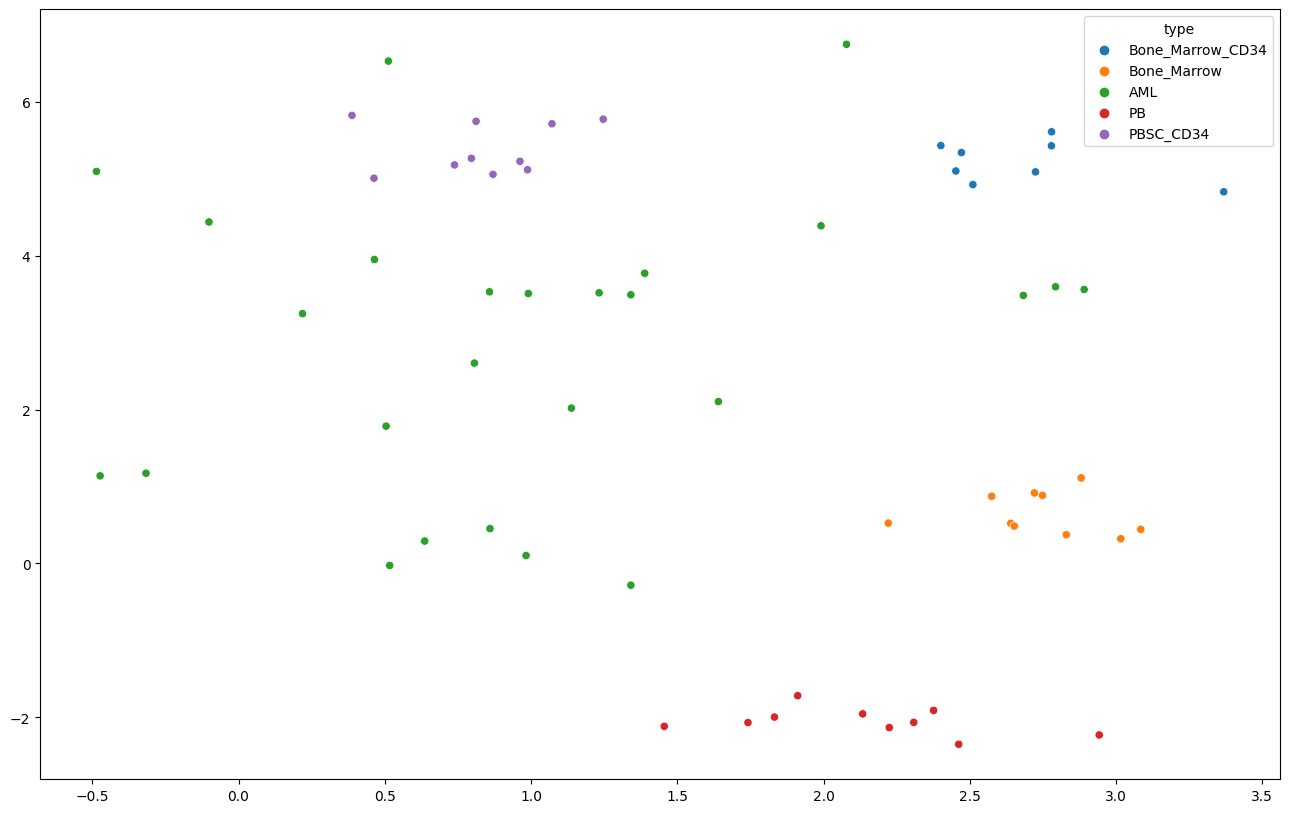

In [30]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=xi, y=yi,
    hue=y,
    legend="full",
    alpha=1
)

### En data escalada

In [31]:
tsne_scaled = TSNE(random_state=0)

In [32]:
tsne_result_scaled = tsne.fit_transform(X_scaled)

In [33]:
xi_scaled = tsne_result_scaled[:, 0]
yi_scaled = tsne_result_scaled[:, 1]

<Axes: >

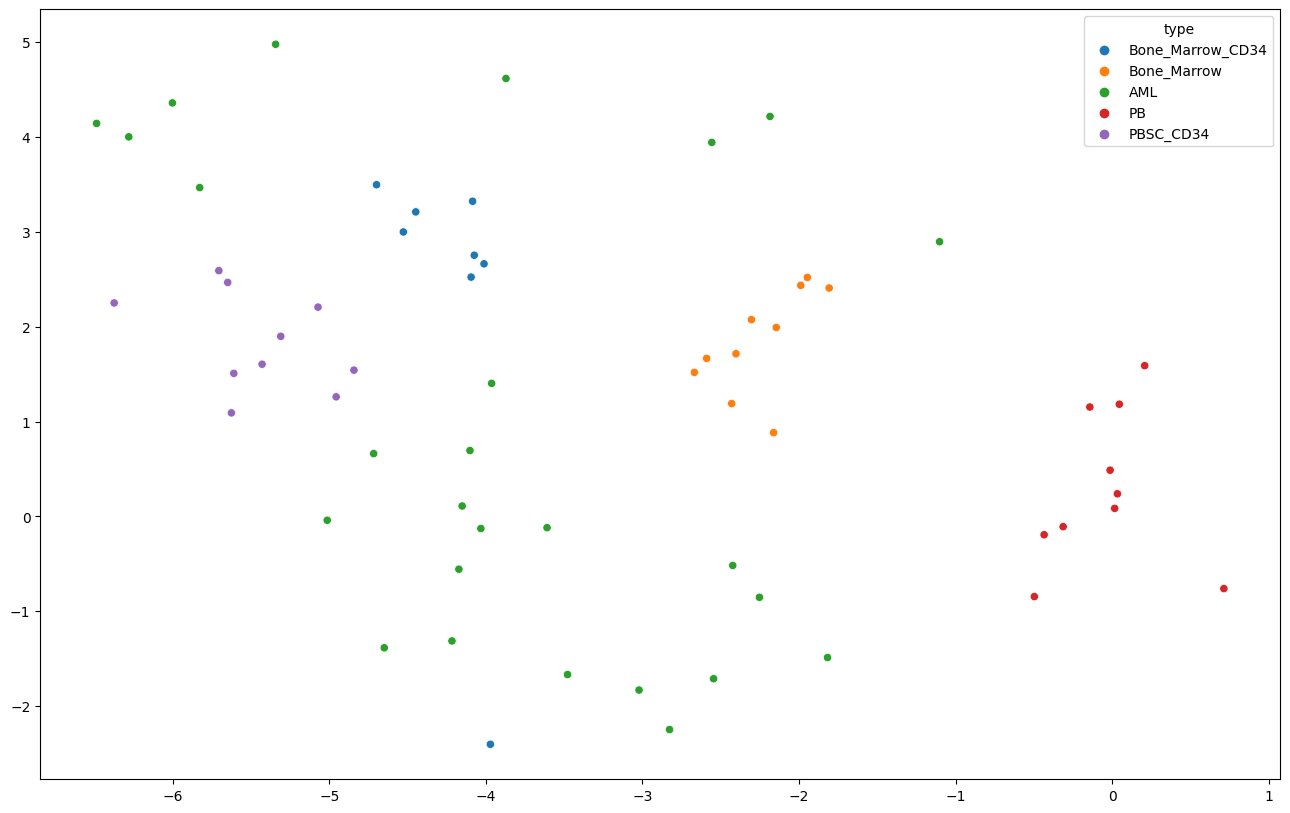

In [34]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=xi_scaled, y=yi_scaled,
    hue=y,
    legend="full",
    alpha=1
)

t-SNE funciona mejor con datos originales que con datos escalados.

Ejecutamos el algoritmo DBScan en datos después de t-SNE con datos originales, ya que t-SNE en datos escalados visualmente no separa los grupos tan bien como con los datos originales.

In [35]:
clusterer_tsne = hdbscan.HDBSCAN(metric='l1', min_cluster_size=6, min_samples=1)

In [36]:
clusterer_tsne.fit(X)

HDBSCAN(metric='l1', min_cluster_size=6, min_samples=1)

In [37]:
clusterer_tsne.labels_, clusterer_tsne.labels_.max()

(array([ 2,  2,  2,  2,  2,  2, -1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0, -1,  0,  0,  0,
         0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3]),
 3)

# Conlusiones

*   Aplicar HDBScan sin modificar los hiperparámetros resulta en un modelo que no clasifica correctamente el número de tipos de cáncer para la data presentada. En teoría, se deberían clasificar 5 tipos, y el modelo original solo consigue 3 clusters.
*   Modificando los hiperparámetros se consigue clasificar la misma cantidad de tipos (3 tipos); sin embargo, se consigue un mejor resultado al reducir el número de puntos clasificados como ruido (-1). No obstante, el resultado sigue sin ser el adecuado para la data mostrada.
*   Aplicamos PCA para tratar de reducir el número de dimensiones, sin embargo, dio un mejor resultado aplicar t-SNE para reducir la dimensionalidad y visualizar los clusters. Luego del análisis con t-SNE en la data no estandarizada y la data estandarizada, se concluyo que el mejor agrupamiento se ven con data NO ESTANDARIZADA.
*   Se aplicó nuevamente HDBScan con la data No Estandarizada procesada con t-SNE y se logró un mejor resultado al lograr 4 clusters. Solo 1 menos de los cluster que nos indica la data.
*   Por último, concluimos que una búsqueda de hiperparámetros podría haber conseguido el mejor de los casos de agrupamiento. Aclarando que quiza el mejor resultado se obtendría aplicando t-SNE en la data No Escalada y luego realizando la búsqueda de los mejores hiperparámetros para HDBScan.

# Referencias

[1] something4kag. "Using HDBSCAN". Kaggle: Your Machine Learning and Data Science Community. https://www.kaggle.com/code/something4kag/using-hdbscan (accedido el 12 de mayo de 2023).

[2] "Basic Usage of HDBSCAN* for Clustering — hdbscan 0.8.1 documentation". The hdbscan Clustering Library — hdbscan 0.8.1 documentation. https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html (accedido el 12 de mayo de 2023).